<a href="https://colab.research.google.com/github/rjarun8/PractiseSets/blob/master/NN-Netcool%20Ticket%20Classification%20M%26A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from string import punctuation
from sklearn.preprocessing import LabelEncoder
import pickle
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from keras import utils

In [47]:
import nltk 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
df=pd.read_excel('/content/netcool_inc_dump.xlsx')

In [0]:
df = df.drop(['Month', 'Incident ID', 'Impact', 'Urgency', 'Priority',
        'Goal Time Hour', 'Priority Goaltime', 'Status', 'Assigned Support Organization',
        'Function','Reported Date', 'Submit Date', 'Restored Date', 'Last Resolved Date','TTR',
        'SLA1', 'SLA2', 'Resolved By',
       'Operational  Categorization Tier 1',
       'Operational  Categorization Tier 2',
       'Operational  Categorization Tier 3', 'Product Categorization Tier 1',
       'Product Categorization Tier 2', 'Product Categorization Tier 3',
       'Resolution Category Tier 1', 'Resolution Category Tier 2',
       'Resolution Category Tier 3',],axis=1)

In [50]:
df

,Assigned Group,Summary,CI Name
0,Wintel Server Applications,Lync : Out of Office Issue,outlook exchange e mail
1,Citrix Server Support,(MPOWER) Multiple User Incident,ukmlwctx128:uk.pri.o2.com
2,Wintel Server Support,Outlook Archive Lost,outlook mail service
3,Wintel Server Support,HP Windows (SNMP) External Array Controller de...,uksthsqlcl001a.uk.pri.o2.com
4,Online Unix Support (ITCC Unix),Clear mail queues in the given list of servers.,verthandi.london.02.net
...,...,...,...
9600,Online Unix Support (ITCC Unix),Alert : SPAMMER,varnish1
9601,Database Support,Usage of the filesystem /opt/oracle is 90% and...,cnmlw-bl860c-13
9602,Backup Support,Cams backup failure opcom in ccdbmanager.,mnbas-bl860c-17
9603,Managed File Transfer Support,MFT - Transfer Error,mnmlw-esxvm-293


In [0]:
df.columns = map(str.lower, df.columns)
df = df.apply(lambda x: x.astype(str).str.lower())
cols=df.columns
df.loc[:, cols] = df[cols].apply(lambda s: s.str.replace(rf'[{punctuation}]', ''))

In [0]:
df.rename(columns={"assigned group": "assigned_group", "ci name": "ci_name"}, inplace=True)


In [53]:
df['assigned_group'].unique()

array(['wintel server applications', 'citrix server support',
       'wintel server support', 'online unix support itcc unix',
       'storage support', 'it platforms support', 'database support',
       'backup support', 'unix support', 'managed file transfer support',
       'ibm power systems operations l1',
       'mobile number reuse support mnr',
       'external mipay it infrastructure use only',
       'ibm power systems support l2', 'wholesale operations',
       'online operations itcc services',
       'external hp it infrastructure use only',
       'external equifax it infrastructure use only',
       'external experian it infrastructure use only',
       'professional services'], dtype=object)

In [0]:
asg_dict={'wintel server applications':'wsa', 'citrix server support':'css',
       'wintel server support':'wss', 'online unix support itcc unix':'ous',
       'storage support':'ss', 'it platforms support':'ips', 'database support':'ds',
       'backup support':'bs', 'unix support':'us', 'managed file transfer support':'mfts',
       'ibm power systems operations l1':'ipso',
       'mobile number reuse support mnr':'mnrs',
       'external mipay it infrastructure use only':'em',
       'ibm power systems support l2':'ipsl2', 'wholesale operations':'wo',
       'online operations itcc services':'oo',
       'external hp it infrastructure use only':'ehp',
       'external equifax it infrastructure use only':'eeq',
       'external experian it infrastructure use only':'eei',
       'professional services':'ps'}

In [0]:
df['ag_code'] = df['assigned_group'].apply(lambda x: asg_dict[x.lower()])

In [56]:
df

,assigned_group,summary,ci_name,ag_code
0,wintel server applications,lync out of office issue,outlook exchange e mail,wsa
1,citrix server support,mpower multiple user incident,ukmlwctx128ukprio2com,css
2,wintel server support,outlook archive lost,outlook mail service,wss
3,wintel server support,hp windows snmp external array controller degr...,uksthsqlcl001aukprio2com,wss
4,online unix support itcc unix,clear mail queues in the given list of servers,verthandilondon02net,ous
...,...,...,...,...
9600,online unix support itcc unix,alert spammer,varnish1,ous
9601,database support,usage of the filesystem optoracle is 90 and ha...,cnmlwbl860c13,ds
9602,backup support,cams backup failure opcom in ccdbmanager,mnbasbl860c17,bs
9603,managed file transfer support,mft transfer error,mnmlwesxvm293,mfts


In [0]:

# generating pkl file for assignemntgroup and ciname

le = LabelEncoder()
encoded_dataframe=pd.DataFrame()
cat_var=['ci_name','assigned_group']
df_new = pd.DataFrame(columns=cat_var)
for cat in cat_var:
    pkl_Filename=cat+'.pkl'
    encoder=le.fit(df[cat].astype(str))
    with open(pkl_Filename, 'wb') as file:
        pickle.dump(encoder, file)

In [0]:
cat_var=['ci_name','assigned_group']
for cat in cat_var:
    pkl = pd.read_pickle(cat+'.pkl')
    df[cat] = pkl.transform(df[cat].astype(str))

In [0]:
df['ag_code'] = df.ag_code.astype('category').cat.codes

In [0]:
df['num_words'] = df.summary.apply(lambda x : len(x.split()))

In [64]:
df['num_words'].unique()

array([ 5,  4,  3, 10,  9,  2,  7,  6, 13,  8, 11, 14, 12,  1, 16, 15, 17,
       18, 19, 20])

In [0]:
df['bins']=pd.cut(df.num_words, bins=[0,5,10,15,20, np.inf], labels=['5', '10', '15','20' ,'25'])

In [102]:
df

,assigned_group,summary,ci_name,ag_code,num_words,bins
0,18,lync office issue,1168,18,5,5
1,1,mpower multiple user incident,1477,1,4,5
2,19,outlook archive lost,1169,19,3,5
3,19,hp window snmp external array controller degra...,1749,19,10,10
4,13,clear mail queue given list server,1790,13,9,10
...,...,...,...,...,...,...
9600,13,alert spammer,1779,13,2,5
9601,2,usage filesystem optoracle 90 exceeded defined...,280,2,13,15
9602,0,cam backup failure opcom ccdbmanager,890,0,6,10
9603,10,mft transfer error,1004,10,3,5


In [0]:
word_distribution = df.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [104]:
word_distribution.head()

,bins,counts
0,5,3815
1,10,3958
2,15,1720
3,20,112
4,25,0


Text(0.5, 1.0, 'Word distribution per bin')

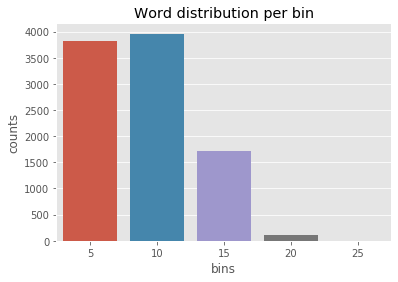

In [105]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [106]:
df.head()

,assigned_group,summary,ci_name,ag_code,num_words,bins
0,18,lync office issue,1168,18,5,5
1,1,mpower multiple user incident,1477,1,4,5
2,19,outlook archive lost,1169,19,3,5
3,19,hp window snmp external array controller degra...,1749,19,10,10
4,13,clear mail queue given list server,1790,13,9,10


In [0]:
num_class = len(np.unique(df.assigned_group.values))

In [108]:
num_class

20

In [0]:
y = df['assigned_group'].values

In [110]:
type(y)

numpy.ndarray

In [78]:
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens =[w for w in tokens if not w in stop] # [w for w in
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in tokens])
    return lemmatized_output
#apply tokenize and lemmatize function
df['summary']=df['summary'].apply(tokenize)

In [111]:
df.head()

,assigned_group,summary,ci_name,ag_code,num_words,bins
0,18,lync office issue,1168,18,5,5
1,1,mpower multiple user incident,1477,1,4,5
2,19,outlook archive lost,1169,19,3,5
3,19,hp window snmp external array controller degra...,1749,19,10,10
4,13,clear mail queue given list server,1790,13,9,10


In [0]:
docs=df['summary'].tolist()
tfidf_vector=TfidfVectorizer(use_idf=True,max_features=1000)
tfidf_vectorizer_vectors=tfidf_vector.fit(docs)
Pkl_Filename='vectorized_cti_netcool.pkl'
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(tfidf_vectorizer_vectors, file)

In [0]:
vect=pd.read_pickle('vectorized_cti_netcool.pkl')
docs=df['summary'].tolist()
tfidf_vectorizer_vectors=vect.transform(docs).todense()
colu=vect.get_feature_names()

In [139]:
len((vect.vocabulary_.keys()))

1000

In [0]:
df1 = pd.DataFrame(tfidf_vectorizer_vectors, columns=colu)

In [112]:
df.columns

Index(['assigned_group', 'summary', 'ci_name', 'ag_code', 'num_words', 'bins'], dtype='object')

In [0]:
res = pd.concat([df1,df[['ci_name','ag_code','num_words','bins']]],axis=1)

In [114]:
res.head()

,001fsf0,01,02,04,04jul2019,07,09,10,100,11,12,2010,2016,2019,2076,2131281223122,23,24,25,2cmp,30,3181,62616720122,80,86,90,9001,9002,9003,9004,9005,9006,9007,9009,9012,9013,9014,9016,9019,9020,...,varunix,vdi,veeam,version,via,view,virtual,vlan,vm,vmhost,vmnic3,vms,vmware,voltage,volume,vpn,vsphere,vulnerability,waiting,warn,warning,web,webportal,weekend,weekly,whenever,wifi,window,within,wmi,wms,work,working,xp12000,zero,zombie,ci_name,ag_code,num_words,bins
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1168,18,5,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1477,1,4,5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1169,19,3,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1749,19,10,10
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1790,13,9,10


In [0]:
sentences_train, sentences_test, y_train, y_test = train_test_split(res,  y, test_size=0.10)

In [0]:
input_dim = sentences_train.shape[1]

In [0]:
y_train = utils.to_categorical(y_train, num_class)
y_test = utils.to_categorical(y_test, num_class)

In [132]:


model = Sequential()
model.add(layers.Dense(32, activation='relu', input_dim=input_dim))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(num_class, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 32)                32160     
_________________________________________________________________
dense_40 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_41 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_42 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_43 (Dense)             (None, 20)                340       
Total params: 33,572
Trainable params: 33,572
Non-trainable params: 0
_________________________________________________________________


In [0]:

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(sentences_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(sentences_test, y_test),
                    batch_size=10,callbacks=[callback])


In [134]:
loss, accuracy = model.evaluate(sentences_train, y_train, verbose=False)
print("Training Accuracy:{:.4f}".format(accuracy))
loss, accuracy = model.evaluate(sentences_test, y_test, verbose=False)
print("Testing Accuracy:{:.4f}".format(accuracy))

Training Accuracy:0.9033
Testing Accuracy:0.8803


In [145]:
inputs = Input(shape=(input_dim, ))
embedding_layer = Embedding(2000,
                            128,
                            input_length=input_dim)(inputs)
x = Flatten()(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
#filepath="weights-simple.hdf5"
#checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(sentences_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(sentences_test, y_test),
                    batch_size=10,callbacks=[callback])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1004)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1004, 128)         256000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 128512)            0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)                4112416   
_________________________________________________________________
dense_53 (Dense)             (None, 20)                660       
Total params: 4,369,076
Trainable params: 4,369,076
Non-trainable params: 0
_________________________________________________________________


In [146]:
loss, accuracy = model.evaluate(sentences_train, y_train, verbose=False)
print("Training Accuracy:{:.4f}".format(accuracy))
loss, accuracy = model.evaluate(sentences_test, y_test, verbose=False)
print("Testing Accuracy:{:.4f}".format(accuracy))

Training Accuracy:0.9999
Testing Accuracy:0.9990
